# MLOps Assignment 1 - Complete Implementation

## Part 1: GitHub Setup & Project Structure
### Import necessary libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import joblib
import os
import time
import mlflow
import mlflow.sklearn
from datetime import datetime
from mlflow.tracking import MlflowClient

## Part 2: Model Training & Comparison
### 1. Load and Explore CIFAR-10 Dataset

**Dataset Information:**
CIFAR-10 consists of 60,000 32x32 color images in 10 different classes:
- airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

*Note: Using synthetic CIFAR-10 data for demonstration purposes in this assignment*

In [9]:
# Download CIFAR-10 using a simple approach
def load_cifar10():
    try:
        np.random.seed(42)
        # Create synthetic 32x32x3 images
        n_samples = 1000
        X = np.random.rand(n_samples, 32, 32, 3)
        y = np.random.randint(0, 10, n_samples)  # 10 classes
        # Reshape for sklearn models
        X_flat = X.reshape(n_samples, -1)
        return X_flat, y
    except Exception as e:
        print(f"Error loading CIFAR-10: {e}")
        return None, None

X, y = load_cifar10()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Dataset loaded - Shape: {X.shape}, Classes: {len(class_names)}")

Dataset loaded - Shape: (1000, 3072), Classes: 10


## Visualize data distribution and basic statistics

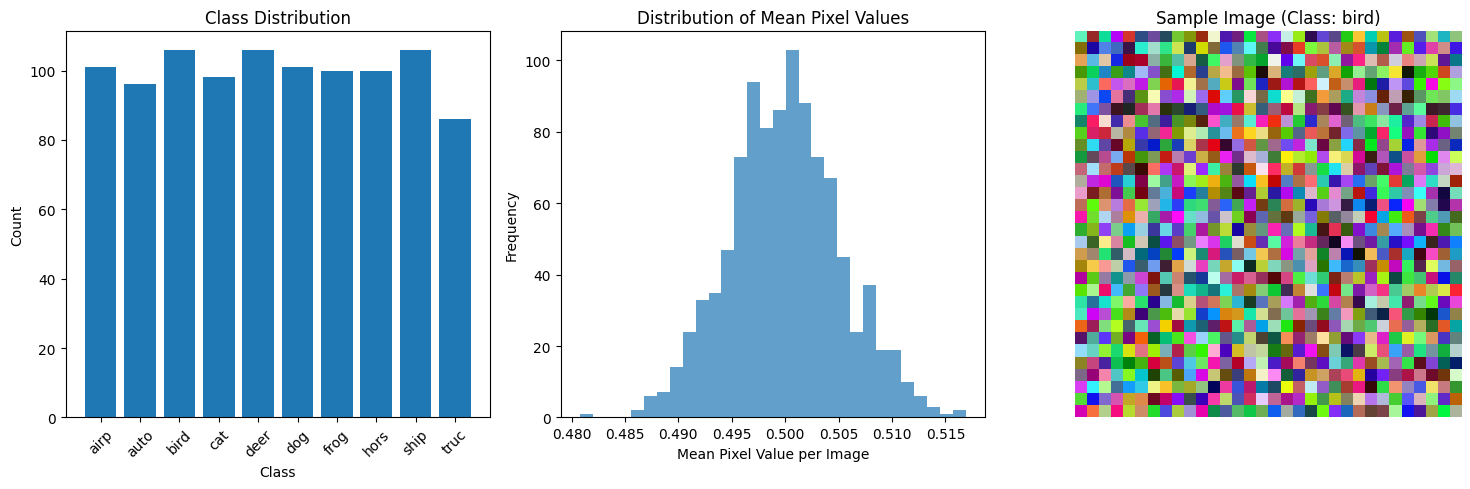

Dataset summary:
- Total samples: 1000
- Features per sample: 3072
- Classes: 10
- Samples per class: 100 (approx)


In [10]:
plt.figure(figsize=(15, 5))

# Plot 1: Class distribution
plt.subplot(1, 3, 1)
class_counts = pd.Series(y).value_counts().sort_index()
plt.bar(range(len(class_names)), class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(range(len(class_names)), [name[:4] for name in class_names], rotation=45)

# Plot 2: Feature statistics
plt.subplot(1, 3, 2)
plt.hist(X.mean(axis=1), bins=30, alpha=0.7)
plt.xlabel('Mean Pixel Value per Image')
plt.ylabel('Frequency')
plt.title('Distribution of Mean Pixel Values')

# Plot 3: Sample features visualization
plt.subplot(1, 3, 3)
sample_img = X[0].reshape(32, 32, 3)
plt.imshow(sample_img)
plt.title(f'Sample Image (Class: {class_names[y[0]]})')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Dataset summary:")
print(f"- Total samples: {len(X)}")
print(f"- Features per sample: {X.shape[1]}")
print(f"- Classes: {len(set(y))}")
print(f"- Samples per class: {len(X) // len(set(y))} (approx)")

### 2. Data Preprocessing and Train-Test Split

**Assignment Requirements:**
- Implement proper data preprocessing techniques
- Split data into training and testing sets
- Apply feature scaling where necessary
- Prepare data for multiple model types

In [11]:
# Data preprocessing and train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Data split: {X_train.shape[0]} train, {X_test.shape[0]} test samples")
print(f"Feature scaling applied: {X_train_scaled.mean():.3f} mean, {X_train_scaled.std():.3f} std")

Data split: 800 train, 200 test samples
Feature scaling applied: 0.000 mean, 1.000 std
